# Word2Vec (Skipgram )

In [1]:
import time, re, json
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [4]:
print("numpy:", np.__version__)
print("torch:", torch.__version__)

numpy: 2.4.1
torch: 2.9.1+cpu


## 1. Load data

In [5]:
import nltk
nltk.download("brown")

from nltk.corpus import brown

def load_news_corpus(max_sentences=20000):
    sents = brown.sents(categories="news")[:max_sentences]
    corpus = []
    for sent in sents:
        toks = [w.lower() for w in sent]
        toks = [w for w in toks if re.fullmatch(r"[a-z]+", w)]
        if len(toks) >= 2:
            corpus.append(toks)
    return corpus

corpus = load_news_corpus(max_sentences=20000)
print("num sentences:", len(corpus))
print("example:", corpus[0][:20])

[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\brown.zip.


num sentences: 4555
example: ['the', 'fulton', 'county', 'grand', 'jury', 'said', 'friday', 'an', 'investigation', 'of', 'recent', 'primary', 'election', 'produced', 'no', 'evidence', 'that', 'any', 'irregularities', 'took']


## 2. Build Vocabulary + Numeralization

In [6]:
from collections import Counter

def build_vocab(corpus, min_count=5, max_vocab=30000):
    counts = Counter(w for sent in corpus for w in sent)
    items = [(w,c) for w,c in counts.items() if c >= min_count]
    items.sort(key=lambda x: x[1], reverse=True)
    items = items[:max_vocab]

    vocabs = [w for w,_ in items]
    vocabs.append("<UNK>")

    word2index = {w:i for i,w in enumerate(vocabs)}
    index2word = {i:w for w,i in word2index.items()}
    return vocabs, word2index, index2word, counts

vocabs, word2index, index2word, raw_counts = build_vocab(corpus, min_count=5, max_vocab=30000)
voc_size = len(vocabs)
print("vocab size:", voc_size)
print("top10:", vocabs[:10])

vocab size: 2373
top10: ['the', 'of', 'and', 'to', 'a', 'in', 'for', 'that', 'is', 'was']


## 3. Prepare train data

In [7]:
def make_skipgrams(corpus, word2index, window_size=2):
    unk = word2index["<UNK>"]
    pairs = []

    for sent in corpus:
        sent_ids = [word2index.get(w, unk) for w in sent]
        for i in range(len(sent_ids)):
            center = sent_ids[i]
            left = max(0, i - window_size)
            right = min(len(sent_ids), i + window_size + 1)
            for j in range(left, right):
                if j == i:
                    continue
                outside = sent_ids[j]
                pairs.append([center, outside])

    return np.array(pairs, dtype=np.int64)

def random_batch(batch_size, pairs):
    idx = np.random.choice(len(pairs), batch_size, replace=False)
    x = pairs[idx, 0].reshape(-1, 1)  # (B,1)
    y = pairs[idx, 1].reshape(-1, 1)  # (B,1)
    return x, y

window_size = 2  # default as required
pairs = make_skipgrams(corpus, word2index, window_size=window_size)
print("num pairs:", len(pairs))
print("sample:", pairs[:5])

num pairs: 306722
sample: [[  0 719]
 [  0 124]
 [719   0]
 [719 124]
 [719 508]]


## 4. Model

$$J(\theta) = -\frac{1}{T}\sum_{t=1}^{T}\sum_{\substack{-m \leq j \leq m \\ j \neq 0}}\log P(w_{t+j} | w_t; \theta)$$

where $P(w_{t+j} | w_t; \theta) = $

$$P(o|c)=\frac{\exp(\mathbf{u_o^{\top}v_c})}{\sum_{w=1}^V\exp(\mathbf{u_w^{\top}v_c})}$$

where $o$ is the outside words and $c$ is the center word

In [8]:
class Skipgram(nn.Module):
    def __init__(self, voc_size, emb_size):
        super().__init__()
        self.embedding_center = nn.Embedding(voc_size, emb_size)
        self.embedding_outside = nn.Embedding(voc_size, emb_size)

    def forward(self, center, outside, all_vocabs):
        # center:  (B,1)
        # outside: (B,1)
        # all_vocabs: (B,V)

        v_c = self.embedding_center(center)                 # (B,1,E)
        u_o = self.embedding_outside(outside)               # (B,1,E)
        U_all = self.embedding_outside(all_vocabs)          # (B,V,E)

        # top term: exp(u_o^T v_c)
        top = torch.exp(u_o.bmm(v_c.transpose(1,2)).squeeze(2))   # (B,1)

        # bottom term: sum_w exp(u_w^T v_c)
        scores_all = U_all.bmm(v_c.transpose(1,2)).squeeze(2)     # (B,V)
        bottom = torch.sum(torch.exp(scores_all), dim=1, keepdim=True)  # (B,1)

        loss = -torch.mean(torch.log(top / (bottom + 1e-12) + 1e-12))
        return loss

## 5. Training

In [ ]:
batch_size = 256
emb_size = 100
lr = 0.001
num_epochs = 10000

# all vocabs tensor (B,V)
all_vocabs = torch.arange(voc_size).unsqueeze(0).expand(batch_size, voc_size)

model = Skipgram(voc_size, emb_size)
optimizer = optim.Adam(model.parameters(), lr=lr)

loss_history = []
start = time.time()

In [10]:
for epoch in range(num_epochs):
    x, y = random_batch(batch_size, pairs)
    center = torch.LongTensor(x)
    outside = torch.LongTensor(y)

    loss = model(center, outside, all_vocabs)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    loss_history.append(loss.item())

    if (epoch + 1) % 200 == 0:
        print(f"Epoch {epoch+1:4d}/{num_epochs} | Loss: {loss.item():.4f}")

train_time = time.time() - start
print("Training time (sec):", train_time)

Epoch  200/10000 | Loss: 20.4832
Epoch  400/10000 | Loss: 18.0486
Epoch  600/10000 | Loss: 17.4276
Epoch  800/10000 | Loss: 15.9112
Epoch 1000/10000 | Loss: 15.8436
Epoch 1200/10000 | Loss: 14.6560
Epoch 1400/10000 | Loss: 12.4492
Epoch 1600/10000 | Loss: 14.3099
Epoch 1800/10000 | Loss: 12.6553
Epoch 2000/10000 | Loss: 12.1677
Epoch 2200/10000 | Loss: 11.9081
Epoch 2400/10000 | Loss: 11.3966
Epoch 2600/10000 | Loss: 10.7757
Epoch 2800/10000 | Loss: 11.5687
Epoch 3000/10000 | Loss: 10.0578
Epoch 3200/10000 | Loss: 9.7204
Epoch 3400/10000 | Loss: 9.5611
Epoch 3600/10000 | Loss: 10.2034
Epoch 3800/10000 | Loss: 10.4213
Epoch 4000/10000 | Loss: 10.4338
Epoch 4200/10000 | Loss: 9.1340
Epoch 4400/10000 | Loss: 9.4683
Epoch 4600/10000 | Loss: 9.1620
Epoch 4800/10000 | Loss: 8.8789
Epoch 5000/10000 | Loss: 7.7007
Epoch 5200/10000 | Loss: 8.3382
Epoch 5400/10000 | Loss: 7.8206
Epoch 5600/10000 | Loss: 8.6287
Epoch 5800/10000 | Loss: 8.4176
Epoch 6000/10000 | Loss: 7.8341
Epoch 6200/10000 | Los

## 6. Plot

In [15]:
#Embeddings
from sklearn.decomposition import PCA

def get_embed(word):
    idx = word2index.get(word, word2index["<UNK>"])
    idx_t = torch.LongTensor([idx])

    v = model.center_embedding(idx_t)
    u = model.outside_embedding(idx_t)
    e = (v + u) / 2.0
    return e[0].detach().cpu().numpy()

# collect embeddings for plotting
words_to_plot = vocabs[:50]
embs = np.array([get_embed(w) for w in words_to_plot])

# reduce to 2D if needed
if embs.shape[1] != 2:
    pca = PCA(n_components=2)
    embs_2d = pca.fit_transform(embs)
    print("PCA variance ratio:", pca.explained_variance_ratio_)
else:
    embs_2d = embs

# plot
plt.figure(figsize=(6,3))
for i, w in enumerate(words_to_plot):
    x, y = embs_2d[i]
    plt.scatter(x, y)
    plt.annotate(w, (x, y), textcoords="offset points", xytext=(5,2))

plt.title("GloVe Word Embeddings (2D Projection)")
plt.show()


AttributeError: 'Skipgram' object has no attribute 'center_embedding'

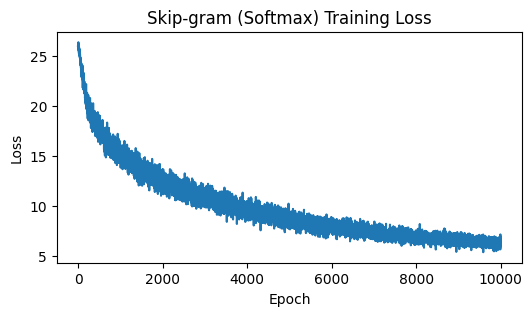

In [14]:
#Loss
plt.figure(figsize=(6,3))
plt.plot(loss_history)
plt.title("Skip-gram (Softmax) Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

## 7. Save model/embeddings

In [12]:
import os

def export_embeddings_skipgram(model, vocabs):

    Wc = model.embedding_center.weight.detach().cpu().numpy()
    Wo = model.embedding_outside.weight.detach().cpu().numpy()
    emb = (Wc + Wo) / 2.0
    return emb

emb = export_embeddings_skipgram(model, vocabs)

save_path = os.path.join("..", "models", f"skipgram_softmax_w{window_size}.npz")
os.makedirs(os.path.dirname(save_path), exist_ok=True)

np.savez(save_path,emb=emb,vocabs=np.array(vocabs, dtype=object),
    window_size=window_size,emb_size=emb_size,lr=lr,num_epochs=num_epochs,train_time=train_time)
print("saved to:", save_path)

saved to: ..\models\skipgram_softmax_w2.npz


## 8. Sanity check

In [13]:
def cosine(a, b):
    a = np.asarray(a); b = np.asarray(b)
    return float(np.dot(a,b) / (np.linalg.norm(a)*np.linalg.norm(b) + 1e-12))

def most_similar(word, topk=10):
    if word not in word2index:
        word = "<UNK>"
    idx = word2index[word]
    q = emb[idx]
    sims = [(vocabs[i], cosine(q, emb[i])) for i in range(len(vocabs))]
    sims.sort(key=lambda x: x[1], reverse=True)
    return sims[:topk]

most_similar("government", topk=10)[:10]

[('government', 1.0000001192092896),
 ('modern', 0.3182024359703064),
 ('birdie', 0.31294187903404236),
 ('william', 0.3004258871078491),
 ('only', 0.29793304204940796),
 ('political', 0.2962496876716614),
 ('won', 0.2899664640426636),
 ('essential', 0.2832108736038208),
 ('books', 0.2772550880908966),
 ('with', 0.2769797444343567)]